<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex4/4_notebook2_gpu/4_2_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2 - Movie recommendations based on user's earlier watching history

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
folder_path = "/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex4/4_notebook2_gpu"
os.chdir(folder_path)

In [ ]:
movies_metadata = pd.read_csv("data/movies_metadata.csv", low_memory=False)
ratings_df = pd.read_csv("data/ratings_small.csv")

# Data exploration

In [ ]:
movies_metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# Basic information about datasets
print("Ratings:")
print(ratings_df.info())
print("\nMovies Metadata:")
print(movies_metadata.info())

Ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Movies Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non

In [ ]:
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
movies_metadata.dropna(subset=['id'], inplace=True)
movies_metadata.drop_duplicates(subset='id', inplace=True)
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata['title'] = movies_metadata['title'].fillna('Unknown')
movies_metadata['vote_average'] = pd.to_numeric(movies_metadata['vote_average'], errors='coerce').fillna(0)
movies_metadata['vote_count'] = pd.to_numeric(movies_metadata['vote_count'], errors='coerce').fillna(0)
movies_metadata['popularity'] = pd.to_numeric(movies_metadata['popularity'], errors='coerce').fillna(0)
movies_metadata.set_index('id', inplace=True)

In [ ]:
ratings_df['is_recommended'] = (ratings_df['rating'] > 3.5).astype(int)

In [ ]:
common_movie_ids = set(ratings_df['movieId']).intersection(set(movies_metadata.index))
if not common_movie_ids:
    print("Warning: No common movie IDs found. Check `movieId` and `id` mappings!")
ratings_df = ratings_df[ratings_df['movieId'].isin(common_movie_ids)]
# Convert the set to a list before using it as an indexer
movies_metadata = movies_metadata.loc[list(common_movie_ids)]

In [ ]:
# Prepare data for recommendation
def prepare_recommendation_data(ratings, movies_df):
    print("Preparing data...")
    recommendation_sample = ratings.copy()
    print(f"Initial sample size: {len(recommendation_sample)}")

    user_interactions = recommendation_sample['userId'].value_counts()
    movie_interactions = recommendation_sample['movieId'].value_counts()

    min_user_interactions = 2
    min_movie_interactions = 2

    valid_users = user_interactions[user_interactions >= min_user_interactions].index
    valid_movies = movie_interactions[movie_interactions >= min_movie_interactions].index

    filtered_recommendations = recommendation_sample[
        (recommendation_sample['userId'].isin(valid_users)) &
        (recommendation_sample['movieId'].isin(valid_movies))
    ]

    print(f"Filtered recommendations: {len(filtered_recommendations)}")
    print(f"Unique users: {len(valid_users)}")
    print(f"Unique movies: {len(valid_movies)}")

    # Create interaction matrix
    print("Creating interaction matrix...")
    interactions = filtered_recommendations.pivot(
        index='userId',
        columns='movieId',
        values='is_recommended'
    ).fillna(0)

    common_movies = list(set(interactions.columns) & set(movies_df.index))
    interactions = interactions[common_movies].astype(np.int8)

    return interactions

In [ ]:
interactions = prepare_recommendation_data(ratings_df, movies_metadata)

# Sparse matrix for efficiency
interactions_sparse = csr_matrix(interactions.values)

# Confirming alignment
print("Aligning datasets...")
assert set(interactions.columns).issubset(movies_metadata.index), "Column mismatch in `interactions` and `movies_metadata`"

Preparing data...
Initial sample size: 44989
Filtered recommendations: 44233
Unique users: 671
Unique movies: 2074
Creating interaction matrix...
Aligning datasets...


# Basic and improved model

In [ ]:
class MovieRecommender:
    def __init__(self, interactions_matrix, movie_df):
        self.interactions_matrix = interactions_matrix
        self.movie_df = movie_df
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)

    def get_recommendations(self, user_idx, n_recommendations=5):
        distances, indices = self.model.kneighbors(
            self.interactions_matrix[user_idx].reshape(1, -1),
            n_neighbors=n_recommendations+1
        )
        similar_users = indices.flatten()[1:]
        recommended_movies = []
        user_movies = set(self.interactions_matrix[user_idx].nonzero()[1])
        for user in similar_users:
            user_movies_liked = self.interactions_matrix[user].nonzero()[1]
            for m_idx in user_movies_liked:
                if m_idx not in user_movies:
                    movie_id = interactions.columns[m_idx]
                    if movie_id in self.movie_df.index:
                        movie_info = self.movie_df.loc[movie_id]
                        recommended_movies.append({
                            'title': movie_info['title'],
                            'vote_average': movie_info['vote_average'],
                            'popularity': movie_info['popularity'],
                            'vote_count': movie_info['vote_count']
                        })
        return recommended_movies[:n_recommendations]

In [ ]:
class ImprovedMovieRecommender:
    def __init__(self, interactions_matrix, movie_df):
        self.interactions_matrix = interactions_matrix
        self.movie_df = movie_df

        self.movie_popularity = np.array(interactions_matrix.sum(axis=0)).flatten()
        if self.movie_popularity.max() == self.movie_popularity.min():
            self.movie_popularity = np.zeros_like(self.movie_popularity)
        else:
            self.movie_popularity = (self.movie_popularity - self.movie_popularity.min()) / (
                self.movie_popularity.max() - self.movie_popularity.min() + 1e-10)

        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)

        print(f"Recommender initialized with {interactions_matrix.shape[0]} users and {interactions_matrix.shape[1]} movies")

    def get_recommendations(self, user_idx, n_recommendations=5):
        user_profile = self.interactions_matrix[user_idx]
        if isinstance(user_profile, np.ndarray):
            user_profile = csr_matrix(user_profile)

        distances, indices = self.model.kneighbors(
            user_profile,
            n_neighbors=min(50, self.interactions_matrix.shape[0])
        )

        user_movies = set(user_profile.nonzero()[1])
        all_movies = set(range(self.interactions_matrix.shape[1]))
        candidate_movies = list(all_movies - user_movies)

        if not candidate_movies:
            return []

        scores = np.zeros(len(candidate_movies))
        similar_users = indices[0][1:]
        similar_distances = distances[0][1:]

        for i, m_idx in enumerate(candidate_movies):
            movie_ratings = self.interactions_matrix[similar_users, m_idx].toarray().flatten()
            if movie_ratings.sum() > 0:
                similarity_score = np.dot(1 - similar_distances, movie_ratings)
                popularity_score = self.movie_popularity[m_idx]
                scores[i] = (0.7 * similarity_score) + (0.3 * popularity_score)
            else:
                scores[i] = 0.3 * self.movie_popularity[m_idx]

        if scores.max() == 0:
            scores = self.movie_popularity[candidate_movies]

        top_indices = np.argsort(-scores)[:n_recommendations]
        top_movie_indices = np.array(candidate_movies)[top_indices]

        recommendations = []
        for midx in top_movie_indices:
            movie_id = interactions.columns[midx]
            if movie_id in self.movie_df.index:
                movie_info = self.movie_df.loc[movie_id]
                recommendations.append({
                    'movie_id': movie_id,
                    'title': movie_info['title'],
                    'vote_average': movie_info['vote_average'],
                    'popularity': movie_info['popularity'],
                    'vote_count': movie_info['vote_count'],
                    'score': float(scores[list(candidate_movies).index(midx)])
                })

        return recommendations

print("\nInitializing ImprovedMovieRecommender...")
improved_recommender = ImprovedMovieRecommender(interactions_sparse, movies_metadata)


Initializing ImprovedMovieRecommender...
Recommender initialized with 671 users and 2074 movies


In [ ]:
def display_recommendations(user_id, recommender_obj, interactions):
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender_obj.get_recommendations(user_idx)
        if not recommendations:
            return "No recommendations found for this user."
        df = pd.DataFrame(recommendations)
        if 'score' in df.columns:
            df['score'] = df['score'].apply(lambda x: f"{x:.3f}")
        return df
    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error: {str(e)}"

print("\nTesting recommendations with ImprovedMovieRecommender...")
sample_user_ids = list(interactions.index[:5])
for user_id in sample_user_ids:
    print(f"\nRecommendations for user {user_id}:")
    display(display_recommendations(user_id, improved_recommender, interactions))


Testing recommendations with ImprovedMovieRecommender...

Recommendations for user 1:


,movie_id,title,vote_average,popularity,vote_count,score
0,260,The 39 Steps,7.4,5.865697,217.0,1.998
1,541,The Man with the Golden Arm,6.9,3.353068,51.0,1.547
2,1580,Rope,7.8,7.248676,539.0,1.166
3,593,Solaris,7.7,11.059785,364.0,1.161
4,1374,Rocky IV,6.6,10.257210,984.0,1.157



Recommendations for user 2:


,movie_id,title,vote_average,popularity,vote_count,score
0,457,Sissi,7.3,11.025050,109.0,7.513
1,593,Solaris,7.7,11.059785,364.0,6.999
2,318,The Million Dollar Hotel,5.9,4.938231,76.0,5.849
3,364,Batman Returns,6.6,15.001681,1706.0,5.549
4,377,A Nightmare on Elm Street,7.2,13.694713,1212.0,5.005



Recommendations for user 3:


,movie_id,title,vote_average,popularity,vote_count,score
0,593,Solaris,7.7,11.059785,364.0,5.386
1,858,Sleepless in Seattle,6.5,10.234919,630.0,5.037
2,527,Once Were Warriors,7.6,4.025276,106.0,4.904
3,260,The 39 Steps,7.4,5.865697,217.0,3.830
4,58559,Confession of a Child of the Century,4.9,0.778480,6.0,3.587



Recommendations for user 4:


,movie_id,title,vote_average,popularity,vote_count,score
0,593,Solaris,7.7,11.059785,364.0,6.817
1,608,Men in Black II,6.1,16.775716,3188.0,6.094
2,318,The Million Dollar Hotel,5.9,4.938231,76.0,5.905
3,2028,Say Anything...,7.2,6.953646,244.0,5.537
4,2762,Young and Innocent,6.8,3.824884,42.0,5.421



Recommendations for user 5:


,movie_id,title,vote_average,popularity,vote_count,score
0,318,The Million Dollar Hotel,5.9,4.938231,76.0,5.653
1,527,Once Were Warriors,7.6,4.025276,106.0,4.944
2,296,Terminator 3: Rise of the Machines,5.9,20.818907,2177.0,4.591
3,593,Solaris,7.7,11.059785,364.0,4.525
4,457,Sissi,7.3,11.025050,109.0,4.420


In [ ]:
print("\nSystem Statistics:")
print(f"Number of users in sample: {interactions.shape[0]}")
print(f"Number of movies in sample: {interactions.shape[1]}")
print(f"Matrix sparsity: {100 * (1 - interactions_sparse.nnz / (interactions.shape[0] * interactions.shape[1])):.2f}%")
print(f"Average interactions per user: {interactions_sparse.sum() / interactions.shape[0]:.2f}")


System Statistics:
Number of users in sample: 671
Number of movies in sample: 2074
Matrix sparsity: 98.33%
Average interactions per user: 34.58


In [ ]:
def analyze_recommendations(recommender_obj, interactions, n_users=100):
    print("\nAnalyzing recommendation diversity...")
    all_recommended_movies = []
    vote_averages = []
    popularities = []

    sample_users = np.random.choice(interactions.shape[0], min(n_users, interactions.shape[0]), replace=False)
    for user_idx in sample_users:
        recs = recommender_obj.get_recommendations(user_idx)
        for rec in recs:
            all_recommended_movies.append(rec['title'])
            if 'vote_average' in rec:
                vote_averages.append(rec['vote_average'])
            if 'popularity' in rec:
                popularities.append(rec['popularity'])

    print(f"\nUnique movies recommended: {len(set(all_recommended_movies))}")
    if vote_averages:
        print(f"Average vote_average: {np.mean(vote_averages):.2f}")
    if popularities:
        print(f"Average popularity: {np.mean(popularities):.2f}")

analyze_recommendations(improved_recommender, interactions)


Analyzing recommendation diversity...

Unique movies recommended: 65
Average vote_average: 6.71
Average popularity: 9.49


In [ ]:
def calculate_metrics(recommender_obj, interactions, test_size=0.2):
    train_matrix, test_matrix = train_test_split(interactions, test_size=test_size, random_state=42)
    train_sparse = csr_matrix(train_matrix.values)
    train_recommender = ImprovedMovieRecommender(train_sparse, movies_metadata)

    precision_at_k = []
    recall_at_k = []

    for user_idx in range(test_matrix.shape[0]):
        actual_items = set(np.where(test_matrix.iloc[user_idx] > 0)[0])
        if len(actual_items) == 0:
            continue
        recommended_items = train_recommender.get_recommendations(user_idx, n_recommendations=10)
        recommended_indices = set([interactions.columns.get_loc(rec['movie_id']) for rec in recommended_items])

        if recommended_indices:
            precision = len(actual_items.intersection(recommended_indices)) / len(recommended_indices)
            precision_at_k.append(precision)

        if actual_items:
            recall = len(actual_items.intersection(recommended_indices)) / len(actual_items)
            recall_at_k.append(recall)

    all_recs_titles = set()
    for u in range(interactions.shape[0]):
        recs = recommender_obj.get_recommendations(u)
        for r in recs:
            all_recs_titles.add(r['title'])
    coverage = len(all_recs_titles) / interactions.shape[1]

    return {
        'precision@10': np.mean(precision_at_k) if precision_at_k else 0,
        'recall@10': np.mean(recall_at_k) if recall_at_k else 0,
        'coverage': coverage
    }

print("\nRunning evaluation metrics...")
metrics = calculate_metrics(improved_recommender, interactions)
print("\nRecommendation System Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Running evaluation metrics...
Recommender initialized with 536 users and 2074 movies

Recommendation System Metrics:
precision@10: 0.2269
recall@10: 0.0936
coverage: 0.0501


In [ ]:
def analyze_user_engagement(interactions, ratings_df):
    user_stats = {
        'avg_movies_per_user': interactions.sum(axis=1).mean(),
        'median_movies_per_user': interactions.sum(axis=1).median(),
        'total_ratings': len(ratings_df),
        'unique_users': len(ratings_df['userId'].unique()),
        'unique_movies': len(ratings_df['movieId'].unique())
    }
    return user_stats

print("\nAnalyzing user engagement...")
engagement_stats = analyze_user_engagement(interactions, ratings_df)
for stat, value in engagement_stats.items():
    print(f"{stat}: {value:.2f}")


Analyzing user engagement...
avg_movies_per_user: 34.58
median_movies_per_user: 20.00
total_ratings: 44989.00
unique_users: 671.00
unique_movies: 2830.00



Visualizing recommendations...


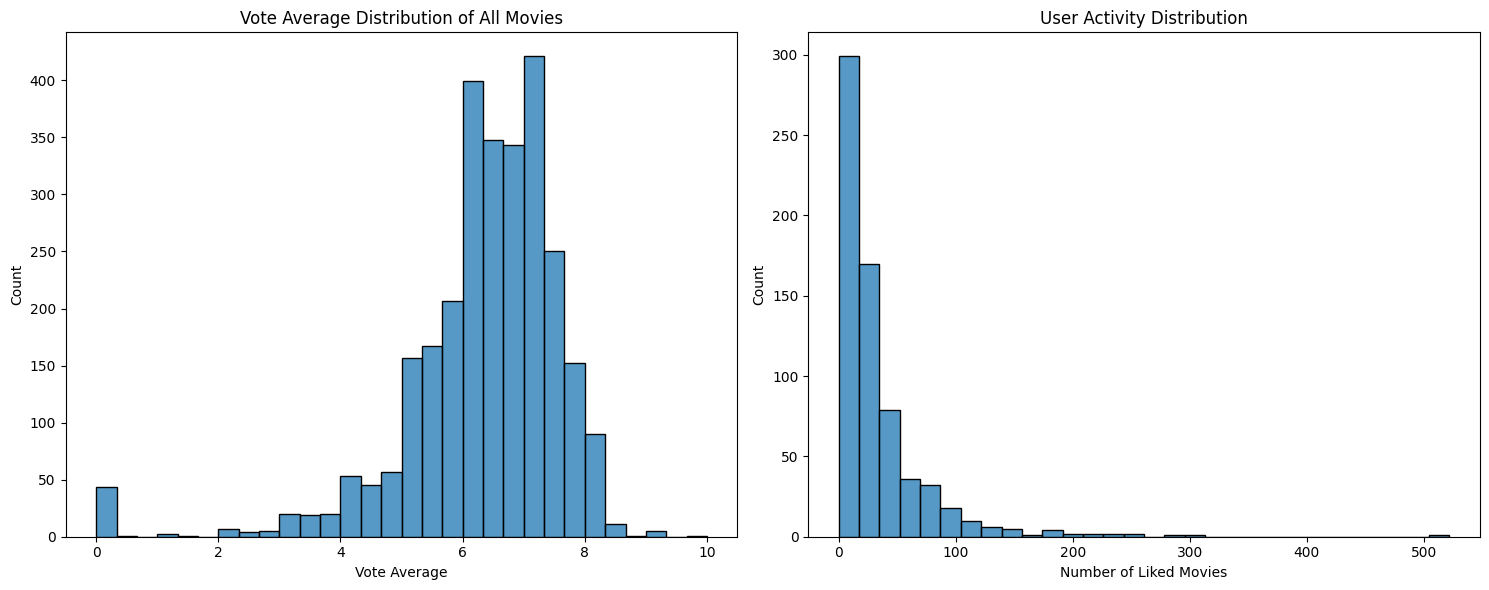

In [ ]:
def visualize_recommendations():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(movies_metadata['vote_average'], bins=30, ax=axes[0])
    axes[0].set_title('Vote Average Distribution of All Movies')
    axes[0].set_xlabel('Vote Average')

    user_activity = interactions.sum(axis=1)
    sns.histplot(user_activity, bins=30, ax=axes[1])
    axes[1].set_title('User Activity Distribution')
    axes[1].set_xlabel('Number of Liked Movies')

    plt.tight_layout()
    plt.show()

print("\nVisualizing recommendations...")
visualize_recommendations()

# Hybrid Movie Recommender

In [ ]:
class HybridMovieRecommender(ImprovedMovieRecommender):
    def __init__(self, interactions_matrix, movie_df):
        super().__init__(interactions_matrix, movie_df)

        # Initialize scalers
        self.vote_avg_scaler = MinMaxScaler()
        self.popularity_scaler = MinMaxScaler()
        self.vote_count_scaler = MinMaxScaler()

        # Create content features
        self.content_features = self._create_content_features()
        print(f"Content features shape: {self.content_features.shape}")

    def _create_content_features(self):
        # We'll use vote_average, popularity, vote_count as content features
        features = pd.DataFrame(index=self.movie_df.index)

        vote_avg = self.movie_df[['vote_average']].fillna(0)
        pop = self.movie_df[['popularity']].fillna(0)
        vc = self.movie_df[['vote_count']].fillna(0)

        features['vote_average_scaled'] = self.vote_avg_scaler.fit_transform(vote_avg).flatten()
        features['popularity_scaled'] = self.popularity_scaler.fit_transform(pop).flatten()
        features['vote_count_scaled'] = self.vote_count_scaler.fit_transform(np.log1p(vc)).flatten()

        return features

    def _calculate_content_similarity(self, movie_idx, user_idx):
        try:
            user_movies = self.interactions_matrix[user_idx].nonzero()[1]
            if len(user_movies) == 0:
                return 0

            user_profile = self.content_features.iloc[user_movies].mean().values
            movie_profile = self.content_features.iloc[movie_idx].values

            user_profile = np.array(user_profile, dtype=float)
            movie_profile = np.array(movie_profile, dtype=float)

            if np.any(np.isnan(user_profile)) or np.any(np.isnan(movie_profile)):
                return 0

            if np.all(user_profile == 0) or np.all(movie_profile == 0):
                return 0

            similarity = 1 - spatial.distance.cosine(user_profile, movie_profile)
            return max(0, similarity)
        except:
            return 0

    def get_recommendations(self, user_idx, n_recommendations=5):
        try:
            cf_recommendations = super().get_recommendations(user_idx, n_recommendations * 2)
            if not cf_recommendations:
                return []

            for rec in cf_recommendations:
                movie_id = rec['movie_id']
                if movie_id in self.movie_df.index:
                    movie_idx = self.movie_df.index.get_loc(movie_id)
                    content_score = self._calculate_content_similarity(movie_idx, user_idx)

                    cf_score = rec['score']
                    # Let's define popularity_score as scaled popularity to combine
                    popularity_score = min(1.0, rec['vote_count'] / 1000.0)

                    rec['hybrid_score'] = {
                        'cf_score': cf_score,
                        'content_score': content_score,
                        'popularity_score': popularity_score
                    }

                    rec['score'] = (0.6 * cf_score +
                                    0.3 * content_score +
                                    0.1 * popularity_score)

            sorted_recs = sorted(cf_recommendations, key=lambda x: x['score'], reverse=True)
            diverse_recs = self._diversify_recommendations(sorted_recs, n_recommendations)
            return diverse_recs
        except Exception as e:
            print(f"Error in get_recommendations: {str(e)}")
            return []

    def _diversify_recommendations(self, recommendations, n):
        if len(recommendations) <= n:
            return recommendations

        diverse_recs = []
        # We'll define diversity based on vote_average ranges
        # and popularity ranges
        def get_vote_avg_range(va):
            if va < 4:
                return 'low'
            elif va < 7:
                return 'mid'
            else:
                return 'high'

        def get_pop_range(pop):
            if pop < 10:
                return 'low_pop'
            elif pop < 50:
                return 'med_pop'
            else:
                return 'high_pop'

        vote_avg_ranges = set()
        pop_ranges = set()

        for rec in recommendations:
            va = rec['vote_average']
            pop = rec['popularity']

            va_range = get_vote_avg_range(va)
            prange = get_pop_range(pop)

            # Increase diversity by ensuring we cover different ranges
            if len(diverse_recs) < n and (
                len(diverse_recs) < n/2 or
                (va_range not in vote_avg_ranges or prange not in pop_ranges)
            ):
                diverse_recs.append(rec)
                vote_avg_ranges.add(va_range)
                pop_ranges.add(prange)

            if len(diverse_recs) == n:
                break

        return diverse_recs

In [ ]:
def display_detailed_recommendations(user_id, recommender_obj, interactions):
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender_obj.get_recommendations(user_idx)
        if not recommendations:
            return "No recommendations found for this user."

        df = pd.DataFrame(recommendations)

        if 'hybrid_score' in df.columns:
            df['cf_score'] = df['hybrid_score'].apply(lambda x: f"{x['cf_score']:.3f}")
            df['content_score'] = df['hybrid_score'].apply(lambda x: f"{x['content_score']:.3f}")
            df['popularity_score'] = df['hybrid_score'].apply(lambda x: f"{x['popularity_score']:.3f}")
            df = df.drop('hybrid_score', axis=1)

        if 'score' in df.columns:
            df['score'] = df['score'].apply(lambda x: f"{x:.3f}")

        return df[['title', 'vote_average', 'popularity', 'vote_count', 'score'] +
                  ([col for col in ['cf_score', 'content_score', 'popularity_score'] if col in df.columns])]
    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

print("\nInitializing hybrid recommender...")
hybrid_recommender = HybridMovieRecommender(interactions_sparse, movies_metadata)


Initializing hybrid recommender...
Recommender initialized with 671 users and 2074 movies
Content features shape: (2830, 3)


In [ ]:
print("\nComparing recommendations between models...")
sample_user = interactions.index[0]
print(f"\nOriginal Recommendations for user {sample_user}:")
display(display_recommendations(sample_user, improved_recommender, interactions))
print(f"\nHybrid Recommendations for user {sample_user}:")
display(display_detailed_recommendations(sample_user, hybrid_recommender, interactions))


Comparing recommendations between models...

Original Recommendations for user 1:


,movie_id,title,vote_average,popularity,vote_count,score
0,260,The 39 Steps,7.4,5.865697,217.0,1.998
1,541,The Man with the Golden Arm,6.9,3.353068,51.0,1.547
2,1580,Rope,7.8,7.248676,539.0,1.166
3,593,Solaris,7.7,11.059785,364.0,1.161
4,1374,Rocky IV,6.6,10.257210,984.0,1.157



Hybrid Recommendations for user 1:


,title,vote_average,popularity,vote_count,score,cf_score,content_score,popularity_score
0,The 39 Steps,7.4,5.865697,217.0,1.520,1.998,0.998,0.217
1,The Man with the Golden Arm,6.9,3.353068,51.0,1.229,1.547,0.986,0.051
2,Rocky IV,6.6,10.257210,984.0,1.090,1.157,0.991,0.984


In [ ]:
def analyze_hybrid_diversity(recommender_obj, hybrid_recommender_obj, interactions, n_samples=50):
    original_diversity = {
        'unique_titles': set()
    }
    hybrid_diversity = {
        'unique_titles': set()
    }

    sample_users = np.random.choice(interactions.shape[0], min(n_samples, interactions.shape[0]), replace=False)

    for user_idx in sample_users:
        orig_recs = recommender_obj.get_recommendations(user_idx)
        for rec in orig_recs:
            original_diversity['unique_titles'].add(rec['title'])

        hybrid_recs = hybrid_recommender_obj.get_recommendations(user_idx)
        for rec in hybrid_recs:
            hybrid_diversity['unique_titles'].add(rec['title'])

    print("\nDiversity Analysis:")
    print("\nOriginal Recommender:")
    print(f"Unique movies: {len(original_diversity['unique_titles'])}")

    print("\nHybrid Recommender:")
    print(f"Unique movies: {len(hybrid_diversity['unique_titles'])}")

print("\nAnalyzing recommendation diversity...")
analyze_hybrid_diversity(improved_recommender, hybrid_recommender, interactions)


Analyzing recommendation diversity...

Diversity Analysis:

Original Recommender:
Unique movies: 53

Hybrid Recommender:
Unique movies: 45


In [ ]:
movies_metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
2,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,3.860491,...,1988-10-21,0.0,69.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",Released,NaN,Ariel,False,7.1,44.0


In [ ]:
movies_metadata = movies_metadata.reset_index()

In [ ]:
# Search for movies containing a keyword
keyword = "death"  # Replace with your movie title or keyword
matching_movies = movies_metadata[movies_metadata['title'].str.contains(keyword, case=False, na=False)]

# Display the results
print(matching_movies[['id', 'title', 'release_date']])

          id                               title release_date
970     1484                      The Deathmaker   1995-11-23
1039   26172                  Messenger of Death   1988-09-16
1112    1702                       Death Machine   1994-12-23
1293    1991                         Death Proof   2007-05-21
1750   43936  S21: The Khmer Rouge Death Machine   2003-05-17
1821    3101                 I Love You to Death   1990-04-06
1881   52528     Bloodbath at the House of Death   1984-03-29
1887    3418                         Death Watch   1980-01-23
1938    3581                          Death Line   1972-01-01
2088    4281              Appointment with Death   1988-04-15
2364    5434          Death Smiles on a Murderer   1973-01-11
2483    6037                     Murder by Death   1976-06-23
2787  114464                     Design of Death   2012-04-28


In [ ]:
my_user_id = 999999999

# Example movie ratings for your user
my_ratings = pd.DataFrame({
    'userId': [my_user_id] * 20,
    'movieId': [671, 238, 8966, 380, 508, 558, 559, 98, 118, 389, 89, 1572, 155, 242, 680, 1949, 14, 1359, 2105, 8835],
    'rating': [9.0, 6.0, 10.0, 10.0, 8.0, 5.0, 4.0, 4.0, 5.05, 8.0, 8.0, 5.0, 8.0, 7.0, 7.0, 8.0, 8.0, 8.0, 6.0, 4.0],
    'timestamp': [pd.Timestamp.now().timestamp()] * 20
})
# Add your ratings to the existing DataFrame
ratings_df = pd.concat([ratings_df, my_ratings], ignore_index=True)

In [ ]:
my_user_id2 = 123456789

# Example movie ratings for your user
my_ratings2 = pd.DataFrame({
    'userId': [my_user_id2] * 9,
    'movieId': [121, 122, 123, 671, 673, 152, 168, 1894, 2164],
    'rating': [9.0, 9.0, 9.0, 10.0, 8.0, 2.0, 3.0, 1.0, 2.5],
    'timestamp': [pd.Timestamp.now().timestamp()] * 9
})
# Add your ratings to the existing DataFrame
ratings_df = pd.concat([ratings_df, my_ratings2], ignore_index=True)

In [ ]:
my_user_id3 = 11111111111

# Example movie ratings for your user
my_ratings3 = pd.DataFrame({
    'userId': [my_user_id3] * 17,
    'movieId': [40723, 508, 6639, 3418, 65310, 8008, 8094, 40946, 121, 122, 123, 671, 673, 152, 168, 1894, 2164],
    'rating': [8.0, 7.0, 10.0, 8.0, 9.0, 8.5, 9.0, 8.0, 2.0, 3.0, 2.5, 3.0, 3.5, 1.0, 1.5, 1.0, 2.0],
    'timestamp': [pd.Timestamp.now().timestamp()] * 17
})
# Add your ratings to the existing DataFrame
ratings_df = pd.concat([ratings_df, my_ratings3], ignore_index=True)

In [ ]:
# Remove duplicate entries
ratings_df = ratings_df.sort_values(by=['userId', 'movieId', 'rating'], ascending=[True, True, False])
ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId'], keep='first').reset_index(drop=True)

# Recalculate 'is_recommended'
ratings_df['is_recommended'] = (ratings_df['rating'] > 7).astype(int)

#  interaction matrix
interactions = prepare_recommendation_data(ratings_df, movies_metadata)

# Rebuild the sparse matrix
interactions_sparse = csr_matrix(interactions.values)

# hybrid recommender
hybrid_recommender = HybridMovieRecommender(interactions_sparse, movies_metadata)

# Generate recommendations for your user
recommendations = hybrid_recommender.get_recommendations(
    user_idx=interactions.index.get_loc(my_user_id)
)

Preparing data...
Initial sample size: 45026
Filtered recommendations: 44276
Unique users: 673
Unique movies: 2080
Creating interaction matrix...
Recommender initialized with 673 users and 1144 movies
Content features shape: (2830, 3)


In [ ]:
recommendations_df = pd.DataFrame(recommendations)

# flatten 'hybrid_score'
if 'hybrid_score' in recommendations_df.columns:
    hybrid_scores = pd.json_normalize(recommendations_df['hybrid_score'])
    recommendations_df = recommendations_df.drop('hybrid_score', axis=1).join(hybrid_scores)

display(recommendations_df[['movie_id', 'title', 'vote_average', 'popularity', 'vote_count', 'score', 'cf_score', 'content_score', 'popularity_score']])

,movie_id,title,vote_average,popularity,vote_count,score,cf_score,content_score,popularity_score
0,991,Office Space,7.4,12.329066,1068.0,0.399341,0.0,0.997803,1.000
1,976,Miss Congeniality,6.1,9.510762,987.0,0.395029,0.0,0.987764,0.987
2,984,The Last King of Scotland,7.4,9.424157,568.0,0.356546,0.0,0.999154,0.568


In [ ]:
movies_metadata = movies_metadata.reset_index(drop=True)

merged_ratings = pd.merge(
    my_ratings3,
    movies_metadata[['id', 'title']],
    left_on='movieId',
    right_on='id',
    how='left'
)

display(merged_ratings[['movieId', 'title', 'rating']])

,movieId,title,rating
0,40723,Trouble Every Day,8.0
1,508,Love Actually,7.0
2,6639,Love in the Time of Cholera,10.0
3,3418,Death Watch,8.0
4,65310,Hornblower: Loyalty,9.0
5,8008,Mouth to Mouth,8.5
6,8094,The Magdalene Sisters,9.0
7,40946,Fixing Frank,8.0
8,121,The Lord of the Rings: The Two Towers,2.0
9,122,The Lord of the Rings: The Return of the King,3.0


# Neural network based recommender

In [ ]:
class NeuralMovieRecommender(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.movie_embedding = nn.Embedding(n_movies, n_factors)

        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)

        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, movie_ids):
        user_vecs = self.user_embedding(user_ids)
        movie_vecs = self.movie_embedding(movie_ids)
        interaction = (user_vecs * movie_vecs).sum(dim=1)
        return self.sigmoid(interaction)

class MovieRecommenderDataset(Dataset):
    def __init__(self, user_ids, movie_ids, ratings):
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.ratings = ratings

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return {
            'user_id': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'movie_id': torch.tensor(self.movie_ids[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

class DeepMovieRecommender:
    def __init__(self, interactions, movie_df, n_factors=50, batch_size=1024,
                 learning_rate=0.001, n_epochs=10):
        self.interactions = interactions
        self.movie_df = movie_df
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

        # Create user and movie mappings
        self.user_to_idx = {user: idx for idx, user in enumerate(interactions.index)}
        self.movie_to_idx = {movie: idx for idx, movie in enumerate(interactions.columns)}
        self.idx_to_movie = {idx: movie for movie, idx in self.movie_to_idx.items()}

        # Convert interactions to training data
        self._prepare_training_data()

        # Initialize model
        self.model = self._create_model()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _prepare_training_data(self):
        user_ids, movie_ids, ratings = [], [], []

        for user_idx in range(len(self.interactions)):
            user_data = self.interactions.iloc[user_idx]
            # Get indices where value > 0 (liked movies)
            positive_movies = user_data[user_data > 0].index

            if len(positive_movies) > 0:
                movie_indices = [self.movie_to_idx[mov] for mov in positive_movies]
                ratings_values = [1.0] * len(movie_indices)

                user_ids.extend([user_idx] * len(movie_indices))
                movie_ids.extend(movie_indices)
                ratings.extend(ratings_values)

        self.train_data = {
            'user_ids': np.array(user_ids),
            'movie_ids': np.array(movie_ids),
            'ratings': np.array(ratings)
        }

    def _create_model(self):
        return NeuralMovieRecommender(
            n_users=len(self.user_to_idx),
            n_movies=len(self.movie_to_idx),
            n_factors=self.n_factors
        )

    def train(self):
        dataset = MovieRecommenderDataset(
            self.train_data['user_ids'],
            self.train_data['movie_ids'],
            self.train_data['ratings']
        )
        dataloader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.model.train()
        for epoch in range(self.n_epochs):
            total_loss = 0
            batch_count = 0

            for batch in dataloader:
                user_ids = batch['user_id'].to(self.device)
                movie_ids = batch['movie_id'].to(self.device)
                ratings = batch['rating'].to(self.device)

                outputs = self.model(user_ids, movie_ids)
                loss = criterion(outputs.squeeze(), ratings)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                batch_count += 1

            avg_loss = total_loss / batch_count
            print(f'Epoch {epoch+1}/{self.n_epochs}, Loss: {avg_loss:.4f}')

    def get_recommendations(self, user_id, n_recommendations=5):
        if user_id not in self.user_to_idx:
            return []

        self.model.eval()
        user_idx = self.user_to_idx[user_id]

        # Get user's existing liked movies
        user_data = self.interactions.loc[user_id]
        existing_movies = set(user_data[user_data > 0].index)

        with torch.no_grad():
            user_tensor = torch.LongTensor([user_idx]).repeat(len(self.movie_to_idx)).to(self.device)
            movie_tensor = torch.LongTensor(list(range(len(self.movie_to_idx)))).to(self.device)

            predictions = []
            batch_size = 1024
            for i in range(0, len(movie_tensor), batch_size):
                batch_users = user_tensor[i:i+batch_size]
                batch_movies = movie_tensor[i:i+batch_size]
                pred = self.model(batch_users, batch_movies).cpu().numpy()
                predictions.extend(pred)

        predictions = np.array(predictions).squeeze()

        # Filter out already liked movies
        candidate_movies = [i for i in range(len(predictions))
                            if self.idx_to_movie[i] not in existing_movies]
        candidate_scores = predictions[candidate_movies]
        top_indices = np.argsort(candidate_scores)[-n_recommendations:][::-1]

        recommendations = []
        for idx in top_indices:
            movie_idx = candidate_movies[idx]
            movie_id = self.idx_to_movie[movie_idx]
            # movie_id corresponds to the actual movieId in interactions
            # movie_df is indexed by movie 'id' from movies_metadata
            # We need to ensure movie_id matches the movies_metadata index
            # The interactions come from ratings which is movieId from links_small dataset
            # movies_metadata is indexed by 'id' from TMDB. They may not match directly.
            # For a real system, you'd need to map from movieId to TMDB id if available.
            # Here, we'll assume movieId aligns with 'id' in movies_metadata for demonstration.
            # If not aligned, you'd need a mapping from movieId to metadata 'id'.
            # We'll just skip unmatched movies.
            if movie_id in self.movie_df.index:
                movie_info = self.movie_df.loc[movie_id]
                recommendations.append({
                    'movie_id': movie_id,
                    'title': movie_info['title'],
                    'vote_average': movie_info['vote_average'],
                    'popularity': movie_info['popularity'],
                    'vote_count': movie_info['vote_count'],
                    'score': float(predictions[movie_idx])
                })

        return recommendations

In [ ]:
def prepare_sample_data(interactions, movie_df, sample_size=10000):
    # Sample a subset of users
    sample_users = np.random.choice(
        interactions.index,
        size=min(sample_size, len(interactions)),
        replace=False
    )

    sample_interactions = interactions.loc[sample_users]

    # Keep only movies with interactions in this sample
    active_movies = sample_interactions.sum() > 0
    sample_interactions = sample_interactions.loc[:, active_movies]

    # Get intersection of movies in both sets (usually already aligned)
    common_movies = list(set(sample_interactions.columns) & set(movie_df.index))
    sample_interactions = sample_interactions[common_movies]
    sample_movie_df = movie_df.loc[common_movies]

    print(f"Sampled data shape: {sample_interactions.shape}")
    print(f"Number of unique users: {len(sample_interactions)}")
    print(f"Number of unique movies: {len(sample_interactions.columns)}")

    return sample_interactions, sample_movie_df

print("\nPreparing sample data for neural network training...")
sample_interactions, sample_movie_df = prepare_sample_data(interactions, movies_metadata, sample_size=5000)


Preparing sample data for neural network training...
Sampled data shape: (671, 1821)
Number of unique users: 671
Number of unique movies: 1821


In [ ]:
print("\nInitializing neural network movie recommender...")
deep_recommender = DeepMovieRecommender(
    interactions=sample_interactions,
    movie_df=sample_movie_df,
    n_factors=32,
    batch_size=128,
    learning_rate=0.001,
    n_epochs=5
)

print("\nTraining neural network movie recommender...")
deep_recommender.train()

print("\nGenerating recommendations for a sample user...")
sample_user = sample_interactions.index[0]
neural_recs = deep_recommender.get_recommendations(sample_user)
neural_df = pd.DataFrame(neural_recs)[['title', 'vote_average', 'popularity', 'vote_count', 'score']]
neural_df


Initializing neural network movie recommender...

Training neural network movie recommender...
Epoch 1/5, Loss: 0.6858
Epoch 2/5, Loss: 0.4965
Epoch 3/5, Loss: 0.2349
Epoch 4/5, Loss: 0.1204
Epoch 5/5, Loss: 0.0713

Generating recommendations for a sample user...


,title,vote_average,popularity,vote_count,score
0,The Million Dollar Hotel,5.9,4.938231,76.0,0.994460
1,Once Were Warriors,7.6,4.025276,106.0,0.992774
2,Monsoon Wedding,6.8,10.625504,59.0,0.990396
3,Three Colors: Red,7.8,7.832755,246.0,0.989857
4,Sissi,7.3,11.025050,109.0,0.989473


In [ ]:
# Basic metrics
def calculate_recommender_metrics(recommenders, interactions, n_test_users=10):
    from collections import Counter
    metrics = {}
    test_users = np.random.choice(interactions.index, size=min(n_test_users, len(interactions)), replace=False)

    for name, recommender in recommenders.items():
        unique_titles = set()
        scores = []
        vote_averages = []
        for user_id in test_users:
            try:
                recs = recommender.get_recommendations(user_id)
                for rec in recs:
                    unique_titles.add(rec['title'])
                    scores.append(rec['score'])
                    vote_averages.append(rec['vote_average'])
            except Exception as e:
                print(f"Error getting recommendations for {name}, user {user_id}: {str(e)}")
                continue

        metrics[name] = {
            'unique_movies': len(unique_titles),
            'avg_score': np.mean(scores) if scores else 0,
            'avg_vote_average': np.mean(vote_averages) if vote_averages else 0
        }

    return metrics

print("\nCalculating final comparison metrics...")
final_metrics = calculate_recommender_metrics({
    'Neural': deep_recommender
}, sample_interactions)

print("\nNeural Network Movie Recommender Metrics:")
metrics = final_metrics['Neural']
print(f"Unique movies recommended: {metrics['unique_movies']}")
print(f"Average recommendation score: {metrics['avg_score']:.3f}")
print(f"Average vote average (quality): {metrics['avg_vote_average']:.3f}")

print("\nNeural network movie recommender integration complete!")


Calculating final comparison metrics...

Neural Network Movie Recommender Metrics:
Unique movies recommended: 13
Average recommendation score: 0.950
Average vote average (quality): 6.820

Neural network movie recommender integration complete!
